<a href="https://colab.research.google.com/github/rlawogjs96/deeplearning_paper_reviews/blob/main/Batch_Normalization_Accelerating_Deep_Network_Training_by_Reducing_Internal_Covariate_Shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch Normalization
Training deep neural networks is quite difficult. Getting deep NNs to converge in a reasonable amount of time can be quite tricky. We introduce a technique called *batch normalization*, a popular and effective technique that consistently accelerates the convergence of deep networks. Batch normalization has made it possible for practioners to routinely train networks with over 100 layers. A secondary benefit of batch normalization is its inherent regularization.



### Training Deep Networks
Batch normalization conveys all three benefits: preprocessing, numerical stability, and regularization. Batch normalization is applied to individual layers, or optionally, to all of them: In each training iteration: we normalize the inputs by subtracting their mean and dividing by their standard deviation, where both are estimated based on the statistics of the current minibatch. We then apply a scale coefficient and an offset to recover the lost degrees of freedom. It is precisely due to this *normalization* based on *batch* statistics that *batch normalization* derives its name. 

#### What is Internal Covariate Shift? 
내부 공변량 변화란 학습 과정에서 층 별로 입력 데이터 분포가 달라지는 현상을 말한다. 이전층의 학습에 의해 이전 층의 가중치 값이 바뀌면서 현재 층에 전달되는 입력 데이터의 분포가 현재 층이 학습했던 시점의 분포와 차이가 발생하는 것이다. Training Data 분포와 Test Data 분포가 다르며 내부적으로 신경망 층 사이에서 발생하는 입력 데이터의 분포 변화를 의미한다. 

정규화를 통하여 학습 속도를 개선하고, Large Learning Rate를 사용할 수 있다. 예를 들어 이미지 데이터의 pixel값이 0 ~ 255라면, 우리는 일반적으로 이 값을 0 ~ 1 또는 -1 ~ 1 로 정규화하여 사용한다. 이렇게 함으로서 더욱 빠른 학습속도를 만들 수 있다. 

#### 배치 정규화의 장점 
  * **학습 속도 (training speed)** 를 빠르게 할 수 있다. 좋은 성능과 빠른 속도를 낼 수 있다. 

  * **가중치 초기화 (weight initialization)** 에 대한 민감도를 감소시킨다. 모델을 만들 때 hyperparameter 세팅에 대한 부담을 덜어준다. 

  * **일반화 (regularization)** 효과를 갖고 있다. 

  궁극적으로 Batch Normalization을 사용하지 않을 이유가 없다. 적은 양의 parameter를 추가하고 BN Layer를 생성함으로서 기하학적으로 모델의 성능을 높일 수 있다. 

일반적인 ResNet18 모델 아키텍쳐 사용. 그 후 CIFAR-10 데이터셋 사용.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import matplotlib.pyplot as plt


# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, with_BN, stride=1):
        super(BasicBlock, self).__init__()
        self.with_BN = with_BN

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn1 = nn.BatchNorm2d(planes) 

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential() # 단순한 identity mapping인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            modules = [nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)]
            if with_BN:
                modules.append(nn.BatchNorm2d(planes))
            self.shortcut = nn.Sequential(*modules)

    def forward(self, x):
        if self.with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
        else:
            out = F.relu(self.conv1(x))
            out = self.conv2(out)
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, with_BN, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.with_BN = with_BN

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, with_BN, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, with_BN, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, with_BN, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, with_BN, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, with_BN, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, with_BN, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        if self.with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            out = F.relu(self.bn1(self.conv1(x)))
        else:
            out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18(with_BN):
    return ResNet(BasicBlock, [2, 2, 2, 2], with_BN)

In [2]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### Training / Test 함수 정의

가장 큰 핵심은 BN을 적용시키지 않은 학습을 진행해보고, BN을 적용시킨 학습을 진행하는 것이다. 그 후 두 가지 모델의 성능을 비교분석한다. 각 모델마다 학습 과정에서의 step에 따른 loss값을 시각화, accuracy 와 loss 값을 시각화한다.

In [3]:
criterion = nn.CrossEntropyLoss() # 분류(classification) 문제


def train(net, optimizer, epoch, step):
    net.train()
    correct = 0 # 정답을 맞힌 이미지 개수
    total = 0 # 전체 이미지 개수
    steps = [] # 학습 스텝(step)
    losses = [] # 각 스텝에서의 손실(loss)

    for _, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

        steps.append(step)
        losses.append(loss.item())
        step += 1

    return correct / total, steps, losses


def test(net, optimizer, epoch):
    net.eval()
    correct = 0 # 정답을 맞힌 이미지 개수
    total = 0 # 전체 이미지 개수
    loss = 0 # 손실(loss)

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    return correct / total, loss

In [5]:
net = ResNet18(with_BN=False).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

In [6]:
without_BN_train_accuracies = []
without_BN_steps = []
without_BN_train_losses = []
without_BN_test_accuracies = []
without_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
    print(f'[ Epoch: {epoch}/{epochs} ]')
    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(without_BN_steps))
    without_BN_train_accuracies.append(train_accuracy)
    without_BN_steps.extend(steps)
    without_BN_train_losses.extend(train_losses)
    print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')

    test_accuracy, test_loss = test(net, optimizer, epoch)
    without_BN_test_accuracies.append(test_accuracy)
    without_BN_test_losses.append(test_loss)
    print(f'Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}')

[ Epoch: 0/20 ]
Train accuracy = 14.47 / Train loss = 869.1028288602829
Test accuracy = 23.63 / Test loss = 205.60107898712158
[ Epoch: 1/20 ]
Train accuracy = 26.47 / Train loss = 772.4002048969269
Test accuracy = 33.21 / Test loss = 185.76193499565125
[ Epoch: 2/20 ]
Train accuracy = 33.58 / Train loss = 702.3508319854736
Test accuracy = 38.11 / Test loss = 167.03959846496582
[ Epoch: 3/20 ]
Train accuracy = 39.45 / Train loss = 641.0530158281326
Test accuracy = 40.24 / Test loss = 161.88050866127014
[ Epoch: 4/20 ]
Train accuracy = 43.87 / Train loss = 595.9774737358093
Test accuracy = 46.27 / Test loss = 145.51828920841217
[ Epoch: 5/20 ]
Train accuracy = 48.66 / Train loss = 552.8187597990036
Test accuracy = 53.02 / Test loss = 128.97906517982483
[ Epoch: 6/20 ]
Train accuracy = 53.53 / Train loss = 505.5004539489746
Test accuracy = 57.46 / Test loss = 118.13176900148392
[ Epoch: 7/20 ]
Train accuracy = 56.53 / Train loss = 477.301631629467
Test accuracy = 60.09 / Test loss = 112.

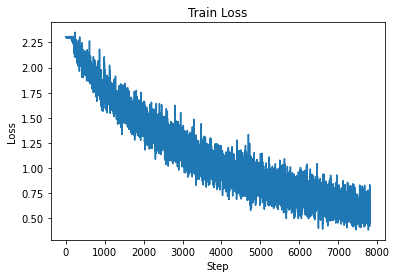

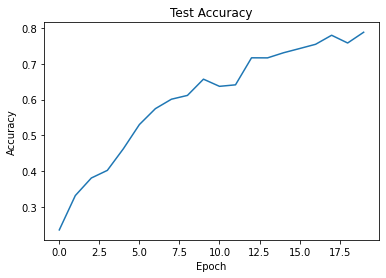

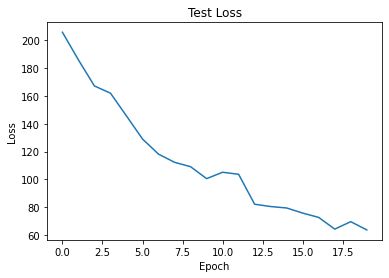

In [7]:
plt.plot(without_BN_steps, without_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

plt.plot([i for i in range(len(without_BN_test_accuracies))], without_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [8]:
net = ResNet18(with_BN=True).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

In [9]:
with_BN_train_accuracies = []
with_BN_steps = []
with_BN_train_losses = []
with_BN_test_accuracies = []
with_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
    print(f'[ Epoch: {epoch}/{epochs} ]')
    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(with_BN_steps))
    with_BN_train_accuracies.append(train_accuracy)
    with_BN_steps.extend(steps)
    with_BN_train_losses.extend(train_losses)
    print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')

    test_accuracy, test_loss = test(net, optimizer, epoch)
    with_BN_test_accuracies.append(test_accuracy)
    with_BN_test_losses.append(test_loss)
    print(f'Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}')

[ Epoch: 0/20 ]
Train accuracy = 47.27 / Train loss = 565.2258674502373
Test accuracy = 56.11 / Test loss = 129.52337181568146
[ Epoch: 1/20 ]
Train accuracy = 65.98 / Train loss = 374.8681129813194
Test accuracy = 69.34 / Test loss = 90.34427803754807
[ Epoch: 2/20 ]
Train accuracy = 74.49 / Train loss = 287.7697993814945
Test accuracy = 73.36 / Test loss = 78.68182277679443
[ Epoch: 3/20 ]
Train accuracy = 79.08 / Train loss = 236.72278609871864
Test accuracy = 78.23 / Test loss = 64.33940604329109
[ Epoch: 4/20 ]
Train accuracy = 81.75 / Train loss = 206.850151181221
Test accuracy = 79.74 / Test loss = 59.61471250653267
[ Epoch: 5/20 ]
Train accuracy = 83.59 / Train loss = 184.41838571429253
Test accuracy = 83.34 / Test loss = 51.146614879369736
[ Epoch: 6/20 ]
Train accuracy = 85.64 / Train loss = 163.51563692092896
Test accuracy = 80.41 / Test loss = 59.18837559223175
[ Epoch: 7/20 ]
Train accuracy = 86.66 / Train loss = 149.06287199258804
Test accuracy = 85.15 / Test loss = 43.77

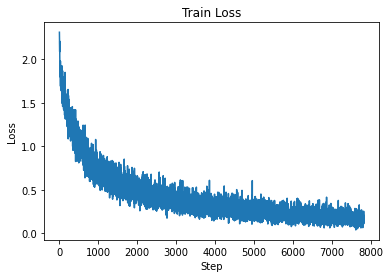

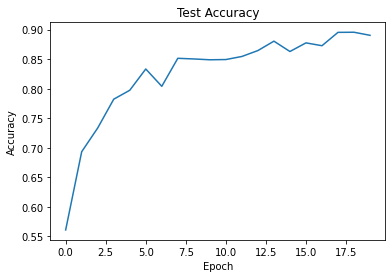

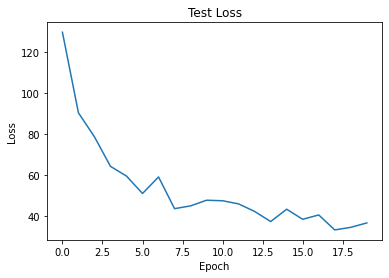

In [10]:
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

plt.plot([i for i in range(len(with_BN_test_accuracies))], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

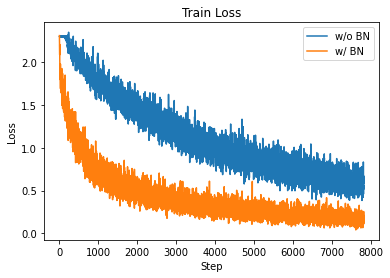

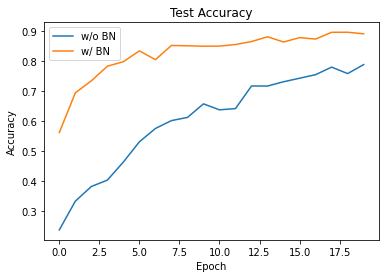

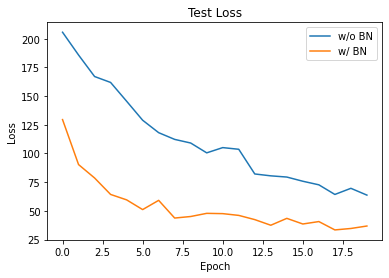

In [11]:
plt.plot(without_BN_steps, without_BN_train_losses)
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

plt.plot([i for i in range(len(without_BN_test_accuracies))], without_BN_test_accuracies)
plt.plot([i for i in range(len(with_BN_test_accuracies))], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()